In [1]:
import gravity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sciopt
import sys
if '..' not in sys.path: sys.path.append('..'); sys.path.append('../external')

from f_ring_util.f_ring import (add_hover,
                                read_ew_stats)

#%matplotlib notebook

In [2]:
obsdata1 = read_ew_stats('../data_files/ISS_006RI_LPHRLFMOV001_PRIME-cs.csv')
obsdata2 = read_ew_stats('../data_files/ISS_093RF_FMOVIE003_PRIME-cs.csv')
obsdata3 = read_ew_stats('../data_files/ISS_039RF_FMOVIE001_VIMS-cs.csv')

** SUMMARY STATISTICS - ../data_files/ISS_006RI_LPHRLFMOV001_PRIME-cs.csv **
Unique observation names: 1
Total slices: 1975
Starting date: 2005-04-13 12:01:20
Ending date: 2005-04-13 13:41:52
Time span: 0 days 01:40:32
** SUMMARY STATISTICS - ../data_files/ISS_093RF_FMOVIE003_PRIME-cs.csv **
Unique observation names: 1
Total slices: 1399
Starting date: 2008-11-14 19:49:51
Ending date: 2008-11-14 21:00:47
Time span: 0 days 01:10:56
** SUMMARY STATISTICS - ../data_files/ISS_039RF_FMOVIE001_VIMS-cs.csv **
Unique observation names: 1
Total slices: 1874
Starting date: 2007-02-27 11:16:47
Ending date: 2007-02-27 12:49:35
Time span: 0 days 01:32:48


In [18]:
def interp_ypts(offset, stretch, ypts, fill=None):
    # The range of longitudes for the original data; we don't care about the 
    # absolute values, only the step size
    old_long = np.arange(len(ypts)) * 0.02

    # Find the new longitudes to sample at based on stretch and offset
    # We want to stretch such that the higher longitudes stay in place and the lower
    # longitudes shrink or enlarge
    new_long = (old_long - old_long[-1] - offset) * stretch + old_long[-1]
    
    # Compute the stretched and offset data using interpolation
    new_ypts = np.interp(new_long, old_long, ypts, left=fill, right=fill)

    return new_ypts

def fit_func(params, ypts1, ypts0):
#     print(params)
    assert len(ypts1) == len(ypts0)
    # offset is specified in degrees
    # stretch is specified as a factor;
    #    1 means leave the original data alone
    #   <1 means shrink the data to be narrower
    #   >1 means grow the data to be wider
    offset, stretch = params
    
    new_ypts0 = interp_ypts(offset, stretch, ypts0, fill=1e38)
    # If the interpolation made the data set shorter, we don't want to compare
    # useless data
    new_ypts1 = ypts1[new_ypts0 != 1e38]
    new_ypts0 = new_ypts0[new_ypts0 != 1e38]
        
    return np.sum((new_ypts1-new_ypts0)**2)

def align_profiles(obsdata, a1, a0, bounds_offset=None, bounds_stretch=None):
    n0 = np.degrees(gravity.SATURN.n(a0, 0.00235))*86400
    n1 = np.degrees(gravity.SATURN.n(a1, 0.00235))*86400
    t1 = 360/n1 # Time for one orbit at a1
    deg0 = t1*n0 # Longitude distance at a0 during time of one orbit at a1
    expected_slope = (deg0-360)/(a1-a0) # deg/km
    if bounds_offset is None:
        bounds_offset = (-3., 3.)
    if bounds_stretch is None:
        # Slope of C-S = -2/3 a/n 1/dt
        # a = 140100 km
        # n = 581.964 deg/day
        # Period of Prometheus = 0.61299 days
        # (Following assumes da is POSITIVE as we move towards Saturn)
        # Slope = 2/3 * 140100 / 581.964 / 0.61299 = 261.6298 km / deg = 0.003822 deg / km
        # This is the slope of the most recent C-S after one Prometheus orbit; the actual slope could
        # be from 0 to this value depending on the age of the C-S
        # C-S start 3.2619 deg apart
        # The required stretch is (3.2619 - 0.003819 * da) / 3.2619
        # We allow a range of 20% on either side
        expected_stretch = (3.2619 - expected_slope * (a1-a0)) / 3.2619
        print('Expected stretch', expected_stretch)
        bounds_stretch = (expected_stretch * .9, expected_stretch)
    ypts1 = obsdata[f'Normal EW{a1} Mean'].to_numpy()
    ypts0 = obsdata[f'Normal EW{a0} Mean'].to_numpy()
    # First normalize each to its mean so they're centered on zero
    norm_ypts1 = ypts1 - np.mean(ypts1)
    norm_ypts0 = ypts0 - np.mean(ypts0)
    # Make the values much larger so the least_squares function looks for a precise answer
    norm_ypts1 *= 1e8
    norm_ypts0 *= 1e8
    
    # Initial guess is no offset and no stretch
    initial_guess = (0., np.mean(bounds_stretch))
    bounds = ((bounds_offset[0], bounds_stretch[0]),
              (bounds_offset[1], bounds_stretch[1]))
    opt = sciopt.least_squares(fit_func, 
                               initial_guess,
                               bounds=bounds,
                               args=(norm_ypts1, norm_ypts0))
    offset = opt['x'][0]
    stretch = opt['x'][1]
    new_ypts0 = interp_ypts(offset, stretch, ypts0)
    
    print('Offset', offset)
    print('Stretch', stretch)
    slope = (1-stretch)*3.2619 / (a1-a0)
    print('Slope ratio', slope / expected_slope)

    return offset, stretch, slope, ypts1, ypts0, new_ypts0

def plot_channels(obsdata, offset, stretch, ypts0):
    new_ypts0 = interp_ypts(offset, stretch, ypts0)
    longitudes = obsdata['Min Long']
    plt.figure()
    plt.plot(longitudes, ypts1-np.mean(ypts1), lw=1, color='blue', label='Primary')
    plt.plot(longitudes, ypts0-np.mean(ypts0), lw=1, color='orange', label='Secondary Orig')
    plt.plot(longitudes, new_ypts0-np.mean(new_ypts0), lw=1, color='red', label='Secondary Opt')
    plt.legend()
    plt.show()

Expected stretch 0.9644393932798014
Offset 0.03356808534960586
Stretch 0.9472422460985023
Slope ratio 1.4836010621700426


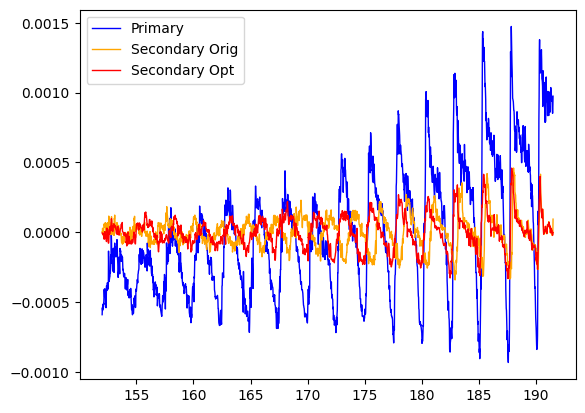

In [19]:
offset, stretch, slope, ypts1, ypts0, new_ypts0 = align_profiles(obsdata1, 140130, 140100)
plot_channels(obsdata1, offset, stretch, ypts0)

Offset 0.008006223024465532
Stretch 0.9952211675633243
Slope ratio 0.8067257436559429


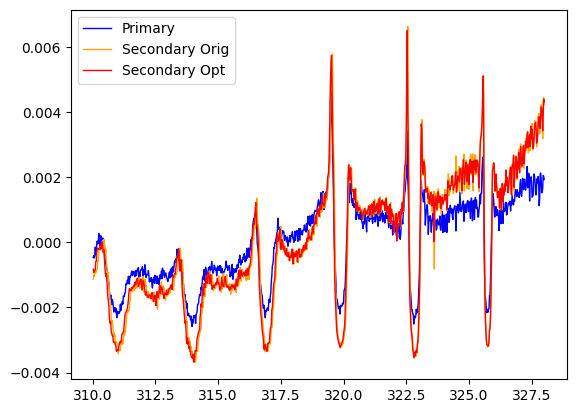

In [20]:
obsdata2_lim = obsdata2[obsdata2['Min Long'] > 310]
offset, stretch, slope, ypts1, ypts0, new_ypts0 = align_profiles(obsdata2_lim, 140170, 140165, 
                                                                 bounds_stretch=(0.95, 1),
                                                                 bounds_offset=(0,2))
plot_channels(obsdata2_lim, offset, stretch, ypts0)

Expected stretch 0.9644317285450579
Offset -0.0048430238679346045
Stretch 0.9472041214672959
Slope ratio 1.4843532275552336


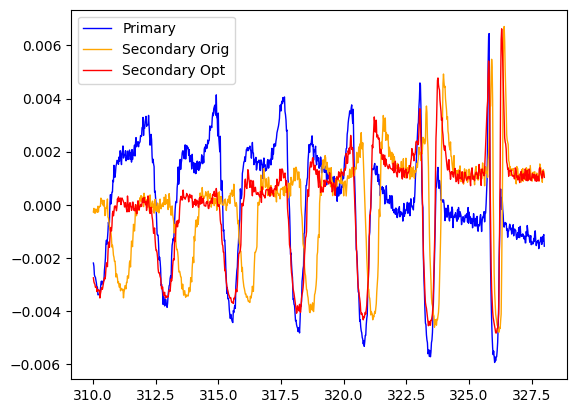

In [21]:
offset, stretch, slope, ypts1, ypts0, new_ypts0 = align_profiles(obsdata2_lim, 140100, 140070)
plot_channels(obsdata2_lim, offset, stretch, ypts0)

Expected stretch 0.8813646625389795
Offset -0.14092909171066978
Stretch 0.8243896648798944
Slope ratio 1.4802531764855065


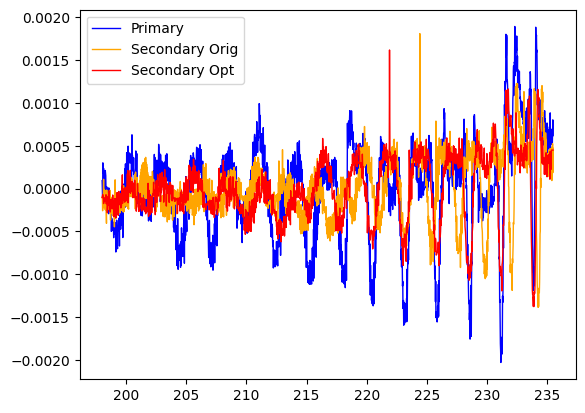

In [22]:
offset, stretch, slope, ypts1, ypts0, new_ypts0 = align_profiles(obsdata3, 140100, 140000)
plot_channels(obsdata3, offset, stretch, ypts0)

140170
Offset 0.03708322805955029
Stretch 0.9870962809231619
Slope ratio 1.0891045357990154
140165
Offset 0.037891530565180145
Stretch 0.9855468263704189
Slope ratio 1.2198383876981578
140160
Offset 0.013102325385788332
Stretch 0.988623157395029
Slope ratio 0.9601635930278055
140155
Offset 0.008917243769776035
Stretch 0.9887525341893649
Slope ratio 0.9492105891768563
140150
Offset 0.007981098316013067
Stretch 0.989399778360141
Slope ratio 0.8945554092711553
140145
Offset 0.003403210448209216
Stretch 0.9912034143100755
Slope ratio 0.7423194580391966
140140
Offset 0.0028787510888102314
Stretch 0.9918837669261316
Slope ratio 0.6848817968585683
140135
Offset 0.013887805472544026
Stretch 0.9874725871458112
Slope ratio 1.0570776956208459
140130
Offset 0.06730024999590374
Stretch 0.9503553958809576
Slope ratio 4.188919129159433
140125
Offset 0.06126329831056077
Stretch 0.9524248152800846
Slope ratio 4.0141612286695825
140120
Offset 0.005711181583695149
Stretch 0.9842919693046202
Slope ratio 1

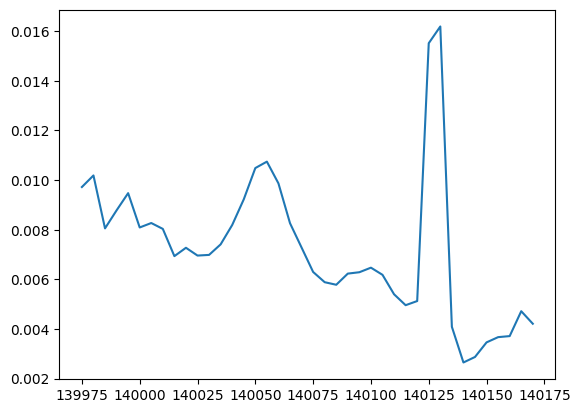

In [23]:
slopes = []
rs = []
for r in range(140170, 139970, -5):
    print(r)
    offset, stretch, slope, ypts1, ypts0, new_ypts0 = align_profiles(obsdata2_lim, r, r-10, bounds_stretch=(0.95, 1),
                                                                 bounds_offset=(0,2))
    rs.append(r)
    slopes.append(slope)
plt.figure()
plt.plot(rs, slopes)


In [ ]:
np.degrees(gravity.SATURN.n(140121.3, 0.00235))*86400